# **Indian Rental House Price-Mumbai**

## **Problem Definition**

**Problem Statement**

The objective of this project is to build a machine learning model to predict residential rental prices in Mumbai based on property characteristics and location information.

Rental prices in metropolitan cities vary significantly due to multiple factors such as property size, number of bedrooms, furnishing level, and geographic location. Accurately estimating rental prices can help:

- Tenants understand fair market rates
- Property owners set competitive pricing
- Real estate platforms provide better price recommendations

**Goal**

Develop an end-to-end machine learning solution that:

- Cleans and prepares raw rental listing data
- Performs exploratory data analysis to identify key price drivers
- Engineers relevant features from property and location information
- Builds and evaluates multiple regression models
- Selects the best-performing model based on predictive accuracy
- Provides insights into the most important factors influencing rental prices

**Target Variable**
- `price` — Monthly rental amount (INR)

**Input Features**
- Property size (sqft)
- Number of bedrooms (BHK)
- Number of bathrooms
- Furnishing status
- Geographic location (latitude and longitude)

The final outcome is a predictive model along with business insights into the factors that most strongly influence rental pricing in Mumbai.


## **Import Libraries**

In [1]:
# Import Libraries

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Markdown, display

## **Load Dataset**

Mount Google Drive in Colab

In [2]:
# Mount google_drive

from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

Load Dataset

In [ ]:
df=pd.read_csv('/content/drive/Othercomputers/SAGAR LAPTOP DATA/DATA SCIENCE/Projects/Machine-Learning-Portfolio/03_ML_Practice/Indian Rental House Price/raw_data/Indian_housing_Mumbai_data.csv')

## **Understanding the Dataset**

### **First look of the Dataset**

#### **Top 5 rows**

In [ ]:
# top 5 rows
print("Top 5 rows : ")
df.head()

#### **Last 5 rows**

In [ ]:
# last 5 rowas
print("Last 5 rows : ")
df.tail()

#### **Columns in the dataset**

In [ ]:
#view of total columns in the dataset
df.columns

#### **Shape of the dataset**


In [ ]:
#shape of the dataset
df.shape

#### **Size of the dataset**

In [ ]:
#size of the dataset
df.size

#### **Information of the dataset**

In [ ]:
# information of the dataset
df.info()

#### **Statistical Summary**

In [ ]:
#statistical summary of the dataset
df.describe()

### **Check Duplicate Values**

In [ ]:
#duplicate values
df.duplicated().sum()

The dataset has 371 duplicated rows , these needs to be removed.

### **Missing Values**

In [ ]:
df.isnull().sum()

**numBathrooms** has 14 missing rows.

**numBalcony** has 4267 missing rows.

**isNegotiable** has 4429 missing rows.

**priceSqft** has 5000 missing rows.

**description** has 78 missing rows.

### **Unique values of each columns**

In [ ]:
df.nunique()

## **Data Wrangling/Cleaning**

### **Remove duplicate records**

In this step we will reomve all the duplicate rows as these rows

1.Prevents the same listing from influencing the model multiple times.

2.Avoids bias toward frequently scraped properties.

3.Improves generalization

In [ ]:
# removing all the 371 duplicate rows from the dataset.
df.drop_duplicates(inplace=True)

In [ ]:
#check duplicae rows again
df.duplicated().sum()

After removing the duplicate rows , checking the shape of dataset

In [ ]:
# Checking the shape of the dataset
df.shape

**Duplicated rows has been removed and now the dataset has 4629 rows**

### **Drop unusable / non-informative columns**

In this step, we remove columns that do not contribute to predicting house rent and may introduce noise, redundancy, or leakage into the regression model.

The goal is not aggressive cleaning, but eliminating columns that are fundamentally unsuitable for a first regression model.

**Columns Dropped and Rationale**

**priceSqFt**

Completely empty (100% missing values)

Cannot be recovered or inferred reliably

**currency**

Only one unique value (INR)

Zero variance → no predictive power

**city**

Dataset is restricted to Mumbai

Redundant feature with no informational value

**isNegotiable**

Present in very few rows

Almost no variance

Weak and unreliable signal

**verificationDate**

Listing metadata, not a house characteristic

Not relevant for rent prediction

**description**

Free-text feature

Requires NLP techniques

Out of scope for baseline regression

In [ ]:
df.drop(['priceSqFt','currency','city','isNegotiable','verificationDate','description'],axis=1,inplace=True)

In [ ]:
df.columns

**Columns Retained (for now)**

These columns are kept for further wrangling or modeling decisions:

house_type

house_size

location

latitude

longitude

price (target)

numBathrooms

numBalconies

SecurityDeposit

Status

Some of these may be excluded later, but they are not dropped prematurely.

### **Converting house_size to Numeric Format**

The house_size column represents the size of the house, which is one of the most important predictors of rent.
However, in its raw form, this column is stored as text, making it unusable for regression models.

In [ ]:
# Create a numeric house size column in square feet

df['house_size_sqft'] = (
    df['house_size']
    .str.lower()                      # normalize text
    .str.replace(',', '', regex=False)  # remove commas
    .str.replace('sq ft', '', regex=False)
    .str.replace('sqft', '', regex=False)
    .str.strip()                      # remove extra spaces
)

# Convert to numeric, invalid parsing -> NaN
df['house_size_sqft'] = pd.to_numeric(df['house_size_sqft'], errors='coerce')

Check

In [ ]:
df[['house_size', 'house_size_sqft']].head()

In [ ]:
df['house_size_sqft'].describe()

New numeric representation of house size (e.g. house_size_sqft)

Suitable for:

Correlation analysis

Regression modeling

Feature interaction analysis

The original house_size column may be retained temporarily for reference but will not be used for modeling.

In [ ]:
df.columns

### **Clean latitude & longitude Columns**

This step fixes invalid geography

What we already know

**From describe():**

Latitude max ≈ 30.88

Longitude max ≈ 91.79

These are not Mumbai.

Mumbai roughly lies within:

Latitude: 18.5 → 19.6

Longitude: 72.7 → 73.3

Anything far outside this is a data error, not a luxury property.

**Check how many rows are outside Mumbai bounds**

In [ ]:
# Define Mumbai bounds
lat_min, lat_max = 18.5, 19.6
lon_min, lon_max = 72.7, 73.3

# Identify rows outside Mumbai bounds
outside_mumbai = df[
    (~df['latitude'].between(lat_min, lat_max)) |
    (~df['longitude'].between(lon_min, lon_max))
]

# Number of such rows
print(f"The number of rows which are outside mumbai are : {outside_mumbai.shape[0]}")

In [ ]:
outside_mumbai[['latitude', 'longitude', 'price']].head()

**Removing the row which have co-cordinates outside Mumbai**

In [ ]:
# Remove rows outside Mumbai geographic bounds
df = df[
    df['latitude'].between(lat_min, lat_max) &
    df['longitude'].between(lon_min, lon_max)
].reset_index(drop=True)

Check

In [ ]:
df[['latitude', 'longitude']].describe()

**Dropping house_size column**

In [ ]:
df.drop('house_size', axis=1, inplace=True)

Check

In [ ]:
df.columns

In [ ]:
df.shape

### **Handling Missing Values**

**Handling missing values in `numBathrooms`**

numBathrooms has 14 missing values

Dataset size is ~4600+ rows

Missing rate is < 0.5%

This is not a data-quality crisis.

Decision

**Impute missing values with the median**

**Why median?**

Bathrooms is a discrete numeric feature

Distribution is slightly skewed

Median is robust to rare high values (5–7 bathrooms)

**Why not drop rows?**

Dropping is also valid

But median imputation keeps data intact

Better for learning + reproducibility

In [ ]:
# Fill missing values in numBathrooms with median
median_bathrooms = df['numBathrooms'].median()
df['numBathrooms'] = df['numBathrooms'].fillna(median_bathrooms)

Check

In [ ]:
df['numBathrooms'].isnull().sum()

After this step, `numBathrooms` is complete and ready for modeling.

### **Extract BHK from house_type**

The `house_type` column contains information about the number of bedrooms
along with property type text (e.g., Apartment, Villa).

For regression modeling, the **number of bedrooms (BHK)** is more important
than the detailed property subtype.



In [ ]:
df['house_type'].value_counts()

What was done
- Extracted the numeric BHK value from the `house_type` text
- Studio apartments (`RK`) were treated as **1 BHK**
- Created a new numeric feature `BHK`

Why this was done
- BHK is a strong structural predictor of rent
- Converting text to numeric makes the feature model-ready
- Keeps the model simple and interpretable

What was intentionally avoided
- No one-hot encoding of property subtypes
- No grouping into luxury categories
- No row removal for rare house types



In [ ]:
# Extract BHK number from house_type
# Replace 'RK' with '1' to treat studio apartments as 1 BHK

df['BHK'] = (
    df['house_type']
    .str.upper()
    .str.replace('RK', '1', regex=False)
    .str.extract(r'(\d+)')
    .astype(float)
)

Check

In [ ]:
df['BHK'].value_counts().sort_index()


In [ ]:
df[['house_type', 'BHK']].head(10)

After this step, `BHK` is available as a clean numeric feature for modeling.

### **Standardize column names**


In [ ]:
df.columns

**Columns that needs to be standardized**

SecurityDeposit -> securitydeposit
Status          -> status
BHK             -> bhk
numBalconies    ->numbalconies
numBathrooms    -> numbathroom

In [ ]:
df.columns = (
    df.columns
    .str.strip()          # remove leading/trailing spaces
    .str.lower()          # convert to lowercase
    .str.replace(' ', '_')  # replace spaces with underscore
    .str.replace('-', '_')  # replace hyphens if any
)

**Check Standardization**

In [ ]:
df.columns

### **Rounding Values**


In [ ]:
df[['latitude','longitude']]

In [ ]:
#rounding up latitude and longitude columns to 2
df[['latitude', 'longitude']] = df[['latitude', 'longitude']].round(2)

**Check after rounding**

In [ ]:
df[['latitude','longitude']]

### **Renaming Columns**



Renaming these 3 column names

numbathrooms      -> num_bathrooms

numbalconies      -> num_balconies

securitydeposit   -> security_deposit

In [ ]:
df = df.rename(columns={'numbathrooms': 'num_bathrooms'})
df = df.rename(columns={'numbalconies': 'num_balconies'})
df = df.rename(columns={'securitydeposit': 'security_deposit'})

**Check Renaming**

In [ ]:
df.columns

### **Final Dropping Irrelevant Columns**

After completing all cleaning and feature transformations, the dataset is finalized
for regression modeling.

**Final Features Used**
- price (target)
- house_size_sqft
- BHK
- numBathrooms
- latitude
- longitude

These features were selected based on:
- interpretability
- predictive relevance
- low noise
- minimal leakage risk

**Final Deduplication**
Exact duplicate rows were removed after all transformations to ensure that
identical listings do not bias the model.

At this stage, the dataset schema is locked and ready for modeling.


In [ ]:
df.head()

In [ ]:
# dropping irrelevant columns

df.drop(['house_type','num_balconies','security_deposit'],axis=1,inplace=True)


**Check after dropping columns**

In [ ]:
df.columns

### **Final Reordering the Columns**

In [ ]:
df =df[['bhk','house_size_sqft','location','latitude','longitude','num_bathrooms','status','price']]

In [ ]:
df.head()

### **Final Deduplicaton**

In [ ]:
df.shape

In [ ]:
# check any duplicate rows
df.duplicated().sum()

In [ ]:
# dropping duplicated rows
df.drop_duplicates(inplace=True)

**Check Shape after dropping duplicated row**

In [ ]:
df.shape

In [ ]:
df.head()

## **Visualization**

### **Univariate Analysis**

#### **Distribution of Price**

In [ ]:
#chart -1 distribution of price
plt.figure(figsize=(15, 5))
sns.histplot(data=df, x='price', bins=50, kde=True,color='purple')
plt.title('Distribution of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

##### **Insights**

Price is highly right-skewed (positively skewed).

Most properties fall in the low to mid-price range.

A few high-priced listings create a long tail (luxury segment).

Outliers present – mean may be misleading.

Median is a better measure of central tendency.

Data is not normally distributed.

Log transformation can help for modeling.

Market is dominated by budget and mid-range housing.

#### **Distribution of House Size**

In [ ]:
#chart - 2 Distribution of House Size

plt.figure(figsize=(15, 5))
sns.histplot(df['house_size_sqft'], bins=40, kde=True,color='purple')
plt.title('House Size Distribution (sqft)')
plt.xlabel('House Size (sqft)')
plt.ylabel('Frequency')
plt.show()

##### **Insights**

House size distribution is right-skewed (positively skewed).

Most properties are concentrated between 500 – 1200 sqft.

Very few large properties (>2000 sqft) form a long tail.

Presence of large-size outliers (luxury or premium homes).

Market demand appears focused on compact to mid-size homes.

Median size is more representative than mean.

Distribution is not normal; transformation may help for modeling.

Indicates dominance of 1–2 BHK or compact 3 BHK units in the dataset.

#### **BHK Count**

In [ ]:
#chart -3 bhk count
plt.figure(figsize=(15, 5))
sns.countplot(data=df, x='bhk',color='purple')
plt.title('BHK Count')
plt.xlabel('BHK')
plt.ylabel('Count')
plt.show()

##### **Insights**

2 BHK is the most common property type, indicating highest market supply and demand.

1 BHK and 3 BHK also form a significant portion of listings.

4+ BHK units are very limited, representing the premium/luxury segment.

The market is largely dominated by small to mid-sized family homes (1–3 BHK).

#### **Furnishing Status Distribution**

In [ ]:
#chart -4 Furnishing Status Distribution

plt.figure(figsize=(10,4))
sns.countplot(data=df, x='status',color='purple')
plt.title('Furnishing Status Distribution')
plt.xlabel('Furnishing Status')
plt.ylabel('Count')
plt.show()

##### **Insights**

Semi-Furnished properties are the most common, indicating highest market availability.

Unfurnished units form a significant portion, showing demand for budget-friendly options.

Fully furnished properties are the least available, likely targeting premium or short-term renters.

The market is largely dominated by semi-furnished and unfurnished homes, suggesting tenants prefer flexibility and moderate pricing.

#### **Top Locations by Listing Count**

In [ ]:
#chart -5 Top Locations by Listing Count
top_locations = df['location'].value_counts().head(30)

plt.figure(figsize=(15, 7))
sns.barplot(x=top_locations.values, y=top_locations.index,color='purple')
plt.title('Top 30 Locations by Listing Count')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

##### **Insights**

Andheri West has the highest number of listings, indicating a major rental hotspot.

Thane West and Kharghar also show high inventory, reflecting strong housing supply in suburban areas.

Listings are concentrated in a mix of Mumbai city areas and extended suburbs, showing demand across budget segments.

Premium locations like Juhu, Worli, and Lower Parel have fewer listings, suggesting limited supply or higher property exclusivity.

#### **Bathrooms Distribution**

In [ ]:
#chart -6 Bathrooms Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='num_bathrooms', data=df,color='purple')
plt.title('Number of Bathrooms Distribution')
plt.show()

##### **Insights**

2 bathrooms are the most common, indicating standard configuration for most homes.

1 and 3 bathroom units also have a noticeable presence, matching smaller and mid-sized families.

Properties with 4+ bathrooms are rare, representing the luxury segment.

The market is largely dominated by functional, mid-range housing (1–3 bathrooms), aligned with 1–3 BHK demand.

### **Bivariate Analysis**

#### **Price vs House Size**

In [ ]:
#chart - 7 Price vs House Size

plt.figure(figsize=(8,4))
sns.scatterplot(x='house_size_sqft', y='price', data=df,color='brown')
plt.title('Price vs House Size')
plt.show()


##### **Insights**

There is a positive relationship between house size and price — larger homes generally cost more.

Most properties are concentrated in the 500–2000 sqft range with moderate pricing.

Price variation increases for larger houses, indicating influence of other factors like location and furnishing.

A few large-size, high-price outliers represent premium or luxury properties.

#### **Price by BHK**

In [ ]:
#chart - 8 Price by BHK

plt.figure(figsize=(6,4))
sns.boxplot(x='bhk', y='price', data=df , color = 'brown')
plt.title('Price Distribution by BHK')
plt.show()


##### **Insights**

Median price increases with BHK, showing larger homes generally cost more.

Price variability rises for higher BHKs, indicating influence of location, size, and amenities.

4 BHK and above show many high-price outliers, representing the luxury segment.

1–2 BHK units have lower and more consistent pricing, forming the budget and mid-range market.

#### **Price by Furnishing Status**

In [ ]:
#chart -9 Price by Furnishing Status

plt.figure(figsize=(6,4))
sns.boxplot(x='status', y='price', data=df,color='brown')
plt.title('Price by Furnishing Status')
plt.show()


##### **Insights**

Furnished properties have the highest median price, reflecting added convenience and amenities.

Semi-furnished units also command relatively higher prices compared to unfurnished ones.

Unfurnished properties have the lowest median price, targeting budget-conscious tenants.

Significant price outliers exist in furnished and semi-furnished categories, indicating premium listings in these segments.

#### **Price by Number of Bathrooms**

In [ ]:
#chart -10 Price by Number of Bathrooms

plt.figure(figsize=(6,4))
sns.boxplot(x='num_bathrooms', y='price', data=df,color='brown')
plt.title('Price vs Number of Bathrooms')
plt.show()


##### **Insights**

Median price increases with the number of bathrooms, indicating higher-value properties offer more bathrooms.

Properties with 1–2 bathrooms dominate the lower price range (budget to mid-range segment).

4+ bathrooms show higher price variability, reflecting luxury or premium homes.

Presence of high-price outliers for 3+ bathrooms suggests the influence of factors like location and house size.

#### **Average Price by Location (Top 10)**

In [ ]:
#chart - 11 Average Price by Location (Top 10)
top_loc_price = df.groupby('location')['price'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,4))
sns.barplot(x=top_loc_price.values, y=top_loc_price.index,color='brown')
plt.title('Top 10 Locations by Average Price')
plt.show()

##### **Insights**

Jacob Circle has the highest average price, indicating a premium rental market.

Locations like Marine Drive, Walkeshwar, and Napeansea Road are among the most expensive, known for luxury housing.

Most top-priced areas are South Mumbai locations, reflecting high demand and prime locality value.

These areas represent the luxury segment, driven by location advantage, connectivity, and premium amenities.

### **Multivariate Analysis**

#### **Correlation Heatmap (Numeric Variables)**

In [ ]:
#chart -12 Correlation Heatmap (Numeric Variables)

plt.figure(figsize=(6,4))
sns.heatmap(df[['price','house_size_sqft','bhk','num_bathrooms','latitude','longitude']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


##### **Insights**

Price has a strong positive correlation with house size (0.73) — larger homes tend to cost more.

BHK (0.59) and number of bathrooms (0.58) also show moderate positive correlation with price.

BHK and bathrooms (0.83) are highly correlated, indicating multicollinearity (they increase together).

Latitude and longitude show weak negative correlation with price, suggesting location coordinates alone don’t fully explain pricing.

Overall, property size and configuration (size, BHK, bathrooms) are the primary drivers of price.

#### **Price vs Size Colored by BHK**

In [ ]:
#chart - 13 Price vs Size Colored by BHK

plt.figure(figsize=(6,4))
sns.scatterplot(x='house_size_sqft', y='price', hue='bhk', data=df)
plt.title('Price vs Size (Colored by BHK)')
plt.show()


##### **Insights**

Higher BHK properties are concentrated in larger size ranges, confirming that BHK increases with house size.

Price increases with both size and BHK, indicating combined impact on property value.

1–2 BHK units dominate the smaller size and lower price segment, representing the budget market.

4+ BHK properties appear in the high-size, high-price range, forming the premium/luxury segment.

#### **Price vs Size Colored by Furnishing Status**

In [ ]:
#chart - 14 Price vs Size Colored by Furnishing Status

plt.figure(figsize=(6,4))
sns.scatterplot(x='house_size_sqft', y='price', hue='status', data=df)
plt.title('Price vs Size by Furnishing Status')
plt.show()


##### **Insights**

Price increases with house size across all furnishing categories.

Semi-furnished and furnished properties dominate the mid to high price ranges.

Unfurnished units are mostly concentrated in the lower price segment.

For similar sizes, furnished/semi-furnished homes generally command higher prices, indicating furnishing adds value.

#### **Geographical Price Distribution (Latitude–Longitude)**

In [ ]:
#chart - 15 Geographical Price Distribution (Latitude–Longitude)

plt.figure(figsize=(6,6))
sns.scatterplot(x='longitude', y='latitude', hue='price', size='price',
                sizes=(20,200), data=df, alpha=0.6)
plt.title('Geographical Distribution of Prices')
plt.show()


##### **Insights**

High-priced properties are concentrated in specific clusters, indicating premium location zones.

Central and South Mumbai areas show higher price density compared to outer regions.

Suburban and peripheral locations mostly fall in the lower to mid-price range.

Location plays a significant role in price variation, confirming strong location-based market segmentation.

#### **Average Price by Location and BHK (Pivot Analysis)**

In [ ]:
#chart -16 Average Price by Location and BHK (Pivot Analysis)

pivot_table = df.pivot_table(values='price', index='location', columns='bhk', aggfunc='mean')
pivot_table.head()


##### **Insights**

Prices increase with BHK within the same location, showing size/configuration impacts rental value.

Some locations (e.g., Agripada) show very high prices for higher BHKs, indicating premium housing demand.

Many locations have missing values (NaN) for higher BHKs, suggesting limited availability of large units.

Budget locations (e.g., Airoli) show moderate price growth across BHKs, reflecting mid-range rental markets.

#### **Pair Plot**

In [ ]:
#chart - 17 Pair Plot
numeric_cols = ['price', 'house_size_sqft', 'bhk', 'num_bathrooms']

sns.pairplot(df[numeric_cols], diag_kind='kde')
plt.show()

##### **Insights**

Price shows a strong positive relationship with house size, confirming size is a major price driver.

BHK and number of bathrooms are highly correlated, indicating similar property configuration growth.

Higher BHK clusters appear in larger size and higher price ranges.

Most properties are concentrated in 2–3 BHK with 1–3 bathrooms, forming the core market segment.

Presence of price and size outliers, representing luxury or premium properties.

## **Conclusion of Visualization**

**Visualization Summary & Key Insights**

Exploratory data analysis was performed to understand the distribution of variables and identify key factors influencing rental prices in Mumbai.

**1. Price Distribution**
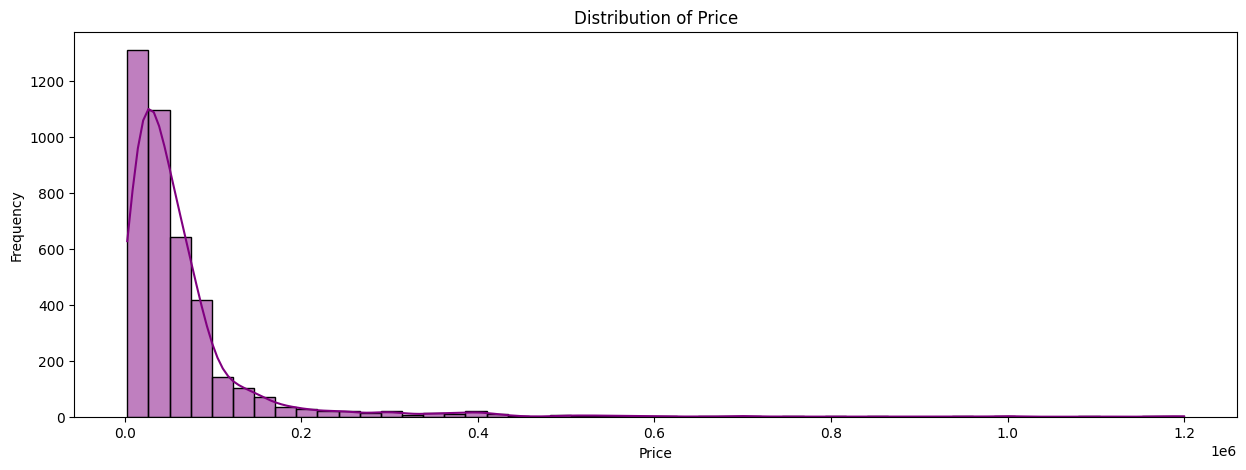
- Rental prices are **highly right-skewed**, with most listings concentrated in the lower to mid-price range.
- A small number of luxury properties create a long tail.
- This suggests that **log transformation of price** may improve model performance for linear models.

**2. Property Size and Structure**

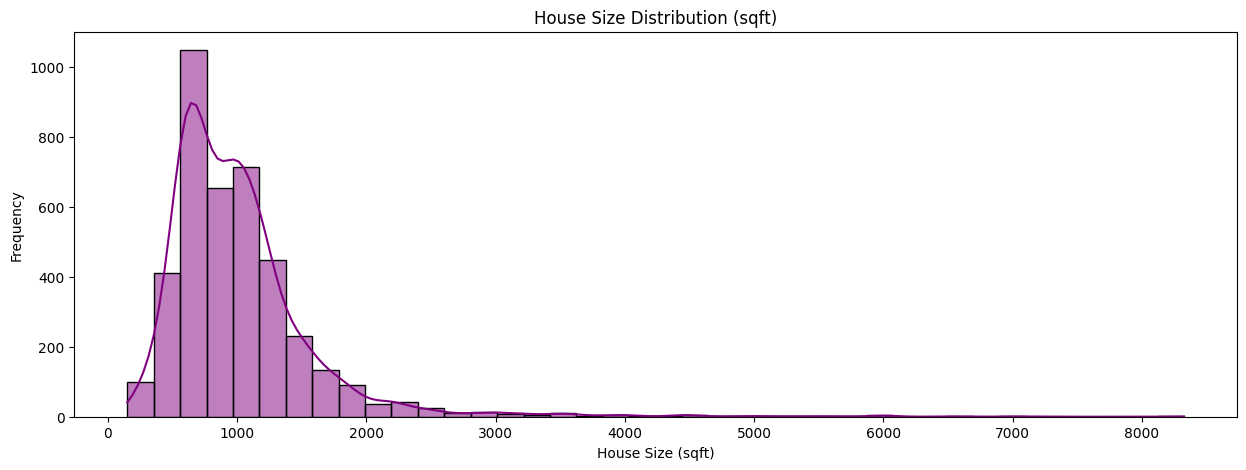

- **House size (sqft)** shows a strong positive relationship with price.
- **BHK and number of bathrooms** also increase consistently with higher rent.
- Structural features (size, BHK, bathrooms) are the **primary drivers of rental value**.

**3. Multicollinearity Observation**
- Strong correlations exist between:
  - BHK and Bathrooms
  - BHK and House Size
  - House Size and Bathrooms  
- These features represent similar structural information and may introduce multicollinearity in linear models.

**4. Furnishing Status**

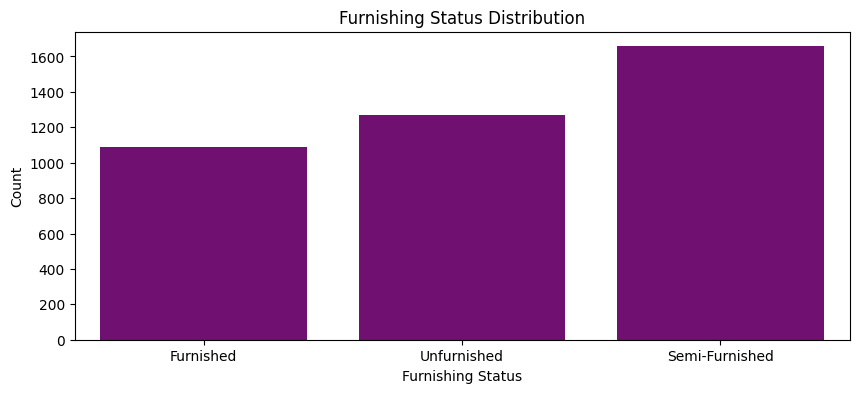

- Furnished and Semi-Furnished properties generally have higher median rents than Unfurnished ones.
- Furnishing level has a **moderate but meaningful impact** on price.
- This feature will be included using **one-hot encoding**.

**5. Location and Spatial Patterns**

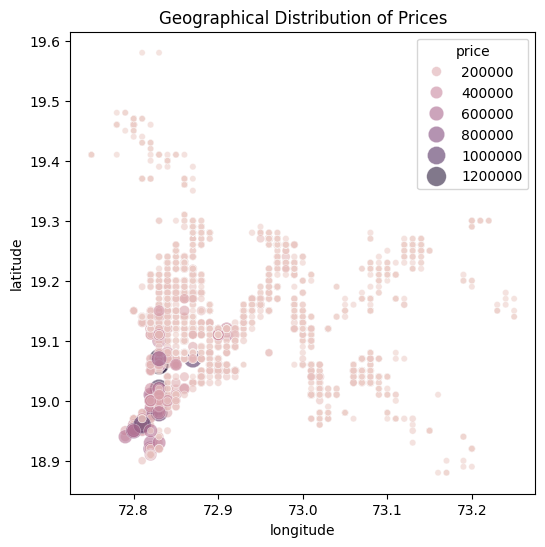

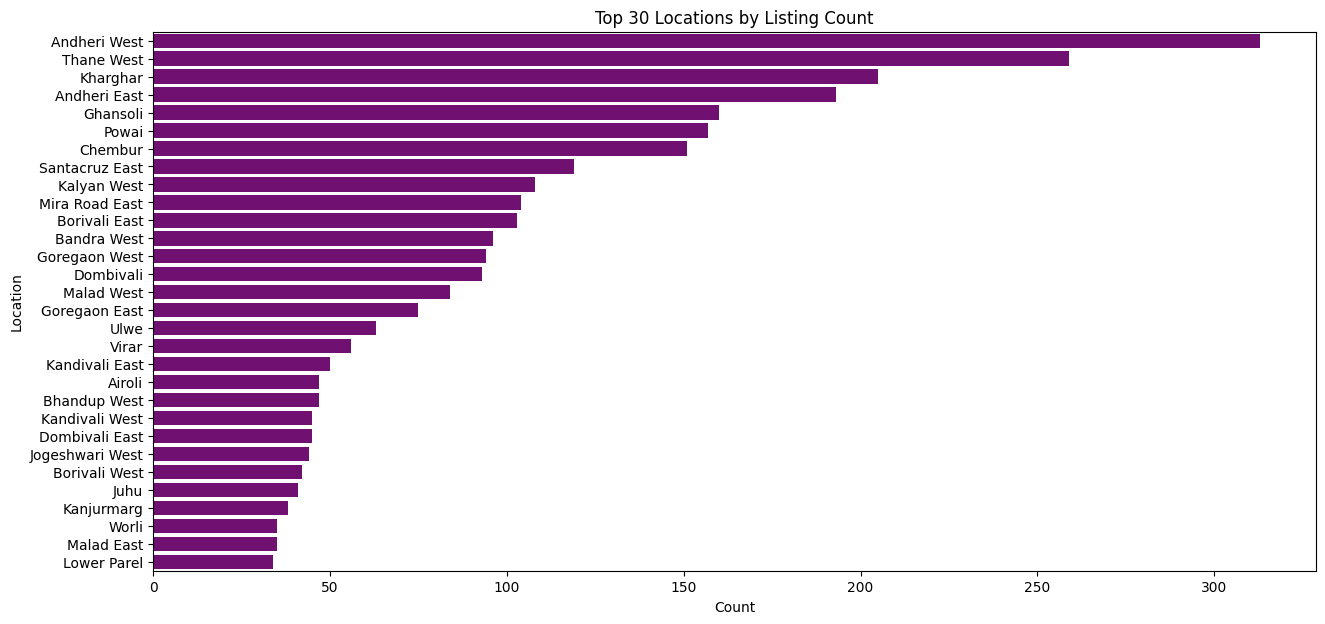

- Rental prices vary significantly across locations.
- High-value properties are geographically clustered in premium areas.
- **Latitude and longitude capture spatial variation effectively**.
- The text-based `location` column has high cardinality and will be excluded from modeling.

**6. Data Distribution Characteristics**
- Majority of listings are **1–2 BHK** with **2 bathrooms**.
- House size is right-skewed with a concentration between 500–1500 sqft.
- The dataset primarily represents mid-market rental properties.

---

**Overall Conclusion**

Rental prices are primarily influenced by:
- Property size
- Structural features (BHK, bathrooms)
- Geographic location

Furnishing status provides additional predictive value, while text-based location will be removed to avoid high-cardinality issues.

The dataset is now well-understood and ready for modeling.


## ------------------------------------- **MACHINE LEARNING** ---------------------------------

## **Final Feature Selection & Modeling Plan**

### **The Plan**



Based on data cleaning and exploratory analysis, the following features were selected for model development.

**Target Variable**
- `price`

Due to the right-skewed distribution of rental prices, a **log transformation of the target variable** will be considered to improve model stability and performance.

---

**Selected Features**

The following variables showed strong or meaningful relationships with price:

**Structural Features**
- `house_size_sqft` – strongest predictor of rent
- `bhk` – captures property layout
- `num_bathrooms` – reflects property utility and comfort level

**Location Features**
- `latitude`
- `longitude`  
These capture spatial variation and price clustering across different areas.

**Property Condition**
- `status` (Furnished / Semi-Furnished / Unfurnished)  
This will be converted into numeric form using **one-hot encoding**.

---

**Features Excluded**

- `location` (text)  
  - High cardinality (~190+ unique values)
  - Would create sparse features and increase overfitting risk
  - Spatial information is already captured by latitude and longitude

- Other metadata and sparse fields removed during earlier cleaning steps.

---

**Final Modeling Dataset**

**Target**
- `price` (or `log(price)`)

**Features**
- `house_size_sqft`
- `bhk`
- `num_bathrooms`
- `latitude`
- `longitude`
- One-hot encoded `status`

---

**Modeling Strategy**

1. Train–Test Split (80–20)
2. Apply preprocessing:
   - Log transformation of target (if used)
   - One-hot encoding for `status`
3. Build baseline models:
   - Linear Regression (interpretability)
   - Tree-based models (handle non-linearity and multicollinearity)
4. Evaluate using:
   - RMSE
   - MAE
   - R²

---

**Next Step**

Proceed with **data splitting and preprocessing pipeline** before model training.


### **Create Modeling Dataset**

**Drop location and keep only required columns**

In [ ]:
# Final modeling columns
model_df = df.drop(columns=['location'])

**Check**

In [ ]:
model_df.columns

### **Separate Features and Target**

In [ ]:
#feature selection
X = model_df.drop('price',axis=1)

#target selection
y = model_df['price']

**Check**

In [ ]:
#check features
X.head()

In [ ]:
#check target
y.head()

### **Train-test Split**

In [ ]:
#import train_test_split from sklearn
from sklearn.model_selection import train_test_split

#train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)

In [ ]:
model_df.shape

**Check shape of train-test split**

In [ ]:
print(f"The dataset has 4015 records.\nThe dataframe is splitted into 80:20.\n80% of data goes to training dataset.\n20% of the data goes to testing.")

print("------------------------------------------------------")

print(f"The shape of X-training dataset is {X_train.shape}")
print(f"The shape of y-training dataset is {y_train.shape}")

print("-----------------------------------------------------")

print(f"The shape of X-testing dataset {X_test.shape}")
print(f"The shape of y-testing dataset {y_test.shape}")

### **Log Transform Target**

**Price is right-skewed.**
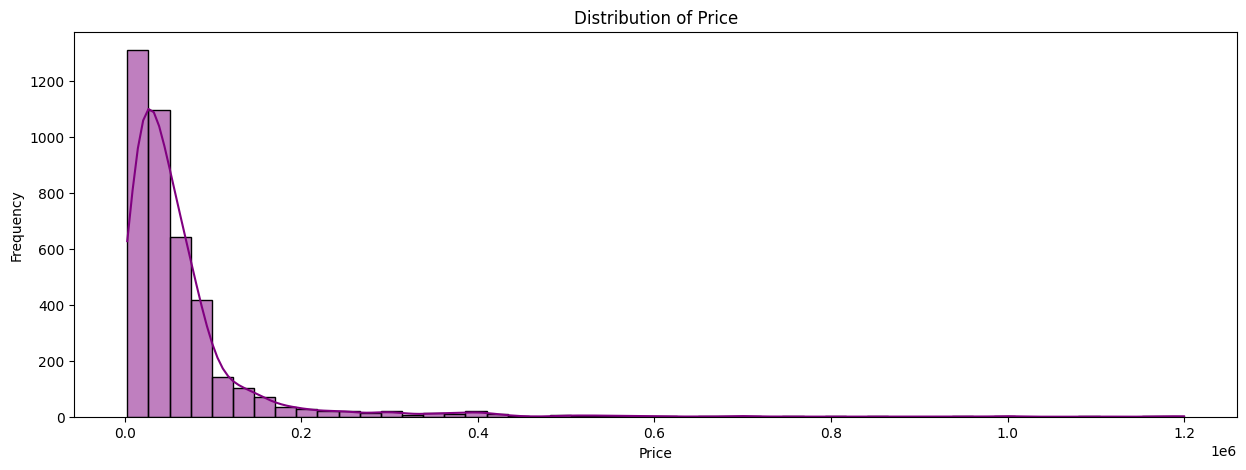

In [ ]:
#applying log_transformation to the target
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

**Check after Log transformation**

In [ ]:
print("\033[1mOriginal y_train skew:\033[0m", y_train.skew().round(2))
print("\033[1mLog-transformed y_train skew:\033[0m", y_train_log.skew().round(2))

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(y_train, kde=True,color='brown')
plt.title("Original Price (y_train)")

plt.subplot(1,2,2)
sns.histplot(y_train_log, kde=True,color='brown')
plt.title("Log Price (y_train_log)")

plt.show()


In [ ]:
print("Original:")
print(y_train.describe())

print("\nLog Transformed:")
print(y_train_log.describe())


The target variable (price) was highly right-skewed.  
A log transformation (`log1p`) was applied, which significantly reduced skewness and made the distribution closer to normal.  
This improves the performance and stability of linear regression models.

### **One-Hot Encode status (after split)**

The dummy variable trap occurs when all categories of a one-hot encoded feature are included, creating perfect multicollinearity. Dropping one category avoids redundancy and ensures stable coefficient estimation in linear models.

In [ ]:
model_df['status'].value_counts()

**Set category order**






In [ ]:
status_order = ['Unfurnished', 'Semi-Furnished', 'Furnished']

X_train['status'] = pd.Categorical(X_train['status'], categories=status_order, ordered=True)
X_test['status'] = pd.Categorical(X_test['status'], categories=status_order, ordered=True)

**Applying one-hot encoding**

In [ ]:
X_train = pd.get_dummies(X_train, columns=['status'], drop_first=True)
X_test = pd.get_dummies(X_test, columns=['status'], drop_first=True)

# Align columns
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

**Check**


In [ ]:
X_train.columns

In [ ]:
X_train[['status_Semi-Furnished', 'status_Furnished']].head()

The status feature was encoded with **Unfurnished as the baseline**.  
The coefficients for Semi-Furnished and Furnished represent the rental premium relative to Unfurnished properties.


**Changing True/False to 1/0**

In [ ]:
status_cols = ['status_Semi-Furnished', 'status_Furnished']

X_train[status_cols] = X_train[status_cols].astype(int)
X_test[status_cols] = X_test[status_cols].astype(int)

In [ ]:
X_train.head()

One-hot encoded status columns were converted from boolean to integer (0/1) for modeling consistency. Unfurnished is treated as the baseline category.


## **Baseline Linear Regression**

### **Train Baseline Linear Regression**

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train_log)

### **Predictions Baseline Linear Regression**

In [ ]:
y_pred_log = model.predict(X_test)

# Convert back to original scale
y_pred = np.expm1(y_pred_log)

### **Model Evaluation Baseline Linear Regression**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("RMSE:", rmse)
print("R²:", r2)

### **Model Performance Summary Baseline Linear Regression**


The baseline Linear Regression model achieved the following results:

- MAE: ₹20,759
- RMSE: ₹57,957
- R²: 0.72

**Interpretation**

The model explains approximately **72% of the variance** in rental prices, indicating that the selected features capture most of the key price drivers.

The average prediction error is around **₹21K**, which is reasonable given the wide variation in rental prices and the presence of high-value luxury properties.

The higher RMSE suggests that the model has larger errors for high-priced properties, which is expected for a simple linear model.

Overall, the baseline model provides a strong foundation for further improvements using more advanced models or additional features.


**Actual vs Predicted Plot**

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.4,color='green')

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--')

plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Prices")
plt.show()

**Residual Plot**

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.4,color='green')

plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Price")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

**Residual Analysis**

The Actual vs Predicted plot shows that the model captures the overall trend but performs poorly for high-priced properties.

The residual plot reveals a funnel-shaped pattern, indicating heteroscedasticity (increasing error variance with price). Large errors are observed for luxury properties.

This suggests that the linear model is unable to capture non-linear relationships and varying price dynamics across different market segments.


## **Model Improvement - Random Forest**

### **Train Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

### **Predicton Random Forest**

In [ ]:
y_pred_rf = rf.predict(X_test)

### **Evaluation Random Forest**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MAE:", mae_rf)
print("Random Forest RMSE:", rmse_rf)
print("Random Forest R²:", r2_rf)

## **Model Comparison**



The Random Forest model significantly improved performance compared to the baseline Linear Regression.

| Metric | Linear Regression | Random Forest |
|---|---|---|
| MAE | ₹20,759 | ₹15,791 |
| RMSE | ₹57,957 | ₹40,294 |
| R² | 0.72 | 0.86 |

### Interpretation

The Random Forest model explains approximately **86% of the variance** in rental prices and reduces the average prediction error by around ₹5,000.

This improvement confirms the presence of **non-linear relationships and feature interactions** in the data, which are better captured by tree-based models.


## **Model Improvement - Cross-Validation**

### **Linear Regression CV**

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr_cv_scores = cross_val_score(
    lr,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("Linear Regression CV R2 scores:", lr_cv_scores)
print("Mean LR CV R2:", lr_cv_scores.mean())
print("Std LR CV R2:", lr_cv_scores.std())

### **Random Forest CV**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

rf_cv_scores = cross_val_score(
    rf,
    X_train,
    y_train,
    cv=5,
    scoring='r2'
)

print("Random Forest CV R2 scores:", rf_cv_scores)
print("Mean RF CV R2:", rf_cv_scores.mean())
print("Std RF CV R2:", rf_cv_scores.std())


### **Cross Validation Results**



5-fold cross-validation was performed to evaluate model stability.

**Linear Regression**
- Mean CV R²: 0.62
- Std: 0.013

The linear model showed stable but relatively low performance, indicating underfitting and inability to capture complex relationships.

**Random Forest**
- Mean CV R²: 0.79
- Std: 0.036

Random Forest achieved significantly higher performance across folds, confirming its ability to capture non-linear patterns and feature interactions.

The cross-validation score is slightly lower than the test score (0.86), suggesting the test split was somewhat optimistic. However, the model demonstrates good overall stability and generalization.


## **Model Comparison**

| Model             | Test R² | CV Mean R² | Conclusion   |
| ----------------- | ------- | ---------- | ------------ |
| Linear Regression | ~0.72   | 0.62       | Underfitting |
| Random Forest     | ~0.86   | 0.79       | Best model   |


## **Model Improvement - Hyperparameter Tuning (Finding the Best estimators)**

### **Finding the best estimator**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_
print(random_search.best_params_)


**Hyperparameter Tuning**

RandomizedSearchCV was used to optimize the Random Forest model.

**Best Parameters**
- n_estimators: 500
- max_depth: 10
- min_samples_split: 2
- min_samples_leaf: 1
- max_features: None

Limiting tree depth reduced overfitting and improved model generalization.

### **Building a Tuned Model on the basis of Hyperparameter**

#### **Applying the Best parameter to the Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_tuned = RandomForestRegressor(
    n_estimators=500,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features=None,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

y_pred_tuned = rf_tuned.predict(X_test)

### **Evaluating the tuned model**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2_tuned = r2_score(y_test, y_pred_tuned)

print("Tuned RF MAE:", mae_tuned)
print("Tuned RF RMSE:", rmse_tuned)
print("Tuned RF R²:", r2_tuned)

| Model                         | MAE    | RMSE   | R²         |
| ----------------------------- | ------ | ------ | ---------- |
| Random Forest (before tuning) | 15,790 | 40,293 | 0.8639     |
| **Tuned Random Forest**       | 15,797 | 40,099 | **0.8652** |


## **Model Comparison - Tuned Random Forest Performance**


| Metric | Before Tuning | After Tuning |
|---|---|---|
| MAE | ₹15,791 | ₹15,797 |
| RMSE | ₹40,294 | ₹40,099 |
| R² | 0.864 | 0.865 |

Hyperparameter tuning resulted in only marginal improvement, indicating that the baseline Random Forest was already close to optimal.

The tuned model, with limited tree depth, provides slightly better generalization while maintaining similar accuracy.

This suggests that further performance gains would require additional features or more data rather than additional model tuning.


## **Additional Model Improvement - Gradient Boosting**

### **Train Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)


### **Evaluate Gradient Boosting**

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
r2_gbr = r2_score(y_test, y_pred_gbr)

print("GBR MAE:", mae_gbr)
print("GBR RMSE:", rmse_gbr)
print("GBR R²:", r2_gbr)




Gradient Boosting Regressor was evaluated to further improve performance.

This model builds trees sequentially and focuses on correcting previous errors, allowing it to capture complex non-linear relationships.

Performance was compared with the tuned Random Forest to select the best final model.


## **Final Model Comparison Summary**

| Model                   | MAE        | RMSE       | R²        |
| ----------------------- | ---------- | ---------- | --------- |
| Linear Regression       | ~20,759    | ~57,957    | 0.72      |
| Random Forest           | 15,791     | 40,294     | 0.864     |
| **Tuned Random Forest** | **15,797** | **40,099** | **0.865** |
| Gradient Boosting       | 16,368     | 42,385     | 0.849     |


## **Model Comparison and Final Selection**



Multiple models were evaluated:

| Model | R² |
|---|---|
| Linear Regression | 0.72 |
| Random Forest | 0.86 |
| Tuned Random Forest | 0.865 |
| Gradient Boosting | 0.85 |

Gradient Boosting did not outperform the tuned Random Forest. The Random Forest model achieved the highest R² and lowest prediction error.

**Final Model**

The **tuned Random Forest** was selected as the final model due to its superior performance and stability.

This confirms that the dataset contains non-linear relationships and feature interactions that are effectively captured by ensemble tree-based methods.


## **Feature Importance from the tuned Random Forest**

### **Get Feature Importance**

In [ ]:
# Get feature importance from tuned model
importances = rf_tuned.feature_importances_

# Create a dataframe
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df


### **Visualization of Feature Importance**

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=feature_importance_df,
    x='Importance',
    y='Feature'
)
plt.title("Feature Importance - Random Forest")
plt.show()


### **Feature Importance Analysis**



Feature importance from the tuned Random Forest model:

| Feature | Importance |
|---|---|
| house_size_sqft | 0.43 |
| longitude | 0.18 |
| latitude | 0.14 |
| num_bathrooms | 0.14 |
| bhk | 0.10 |
| status_Furnished | 0.006 |
| status_Semi-Furnished | 0.006 |

**Key Insights**

- **Property size** is the most important factor, contributing over 40% of the model’s decision power.
- **Location (latitude and longitude)** collectively contributes around 32%, confirming strong geographic influence on rental prices.
- **Structural features** such as number of bathrooms and BHK have moderate impact.
- **Furnishing status** has minimal influence, indicating that size and location dominate rental pricing decisions.

**Business Interpretation**

Rental prices in Mumbai are primarily driven by property size and location, while furnishing level has relatively little impact on price compared to structural and geographic factors.


# **Final Project Summary**


This project developed a machine learning model to predict rental prices in Mumbai using property characteristics and location data.

**Project Workflow**

1. **Data Cleaning & Preparation**
   - Handled missing values and removed irrelevant columns.
   - Extracted numerical features such as `house_size_sqft` and `bhk`.
   - Standardized column names and ensured proper data types.
   - Retained latitude and longitude for spatial price analysis.
   - One-hot encoded furnishing status with *Unfurnished* as the baseline.

2. **Exploratory Data Analysis**
   - Rental prices were found to be **right-skewed**.
   - Strong relationships observed between price and:
     - Property size
     - BHK
     - Number of bathrooms
     - Location
   - Furnishing status showed comparatively smaller impact.
   - High multicollinearity observed among structural features.
   - Clear geographic clustering of high-value areas.

3. **Model Development**
   - **Baseline Model:** Linear Regression  
     - R² ≈ 0.72  
     - Underfitting observed due to non-linear relationships.
   
   - **Advanced Model:** Random Forest  
     - Significant improvement with R² ≈ 0.86.
     - Cross-validation mean R² ≈ 0.79 confirmed model stability.
   
   - **Hyperparameter Tuning**
     - Optimized tree depth and number of estimators.
     - Final tuned model achieved:
       - **R²: 0.865**
       - **MAE: ~₹15,800**
       - **RMSE: ~₹40,000**

   - **Model Comparison**
     - Gradient Boosting was also tested but did not outperform Random Forest.
     - Tuned Random Forest selected as the final model.

---

**Key Insights (Business Perspective)**

Feature importance analysis revealed:

- **Property size (43%)** is the strongest driver of rental price.
- **Location (32%)** has major influence, confirming geographic price variation.
- **Bathrooms and BHK** contribute moderately.
- **Furnishing status (<2%)** has minimal impact compared to size and location.

**Conclusion:**  
Rental pricing in Mumbai is primarily driven by **property size and location**, while furnishing level plays a secondary role.

---

**Model Limitations**

- Dataset does not include important factors such as:
  - Building age
  - Floor level
  - Amenities
  - Parking availability
  - Neighborhood quality
- Performance may improve with additional features and larger datasets.

---

**Final Outcome**

The project demonstrates a complete end-to-end machine learning workflow:

- Data cleaning and wrangling  
- Exploratory data analysis  
- Feature engineering  
- Model building and comparison  
- Cross-validation and tuning  
- Feature importance and business interpretation  

The final tuned Random Forest model provides strong predictive performance and actionable insights into the key factors influencing rental prices.
